In [1]:
#export
from k1lib.callbacks import Callback, Cbs; from k1lib import fmt, cli
import k1lib, torch, math, gc, numpy as np; from functools import partial
import matplotlib.pyplot as plt

In [2]:
#export
def allocated() -> int: return torch.cuda.memory_allocated()
class MemoryData: # handles hooks of 1 nn.Module
    def __init__(self, mProfiler, mS:k1lib.selector.ModuleSelector):
        self.mProfiler = mProfiler; self.mS = mS
        self.handles = k1lib.Object.fromDict({"fp":0,"f":0,"b":0})
        self.values = k1lib.Object.fromDict({"fp":0,"f":0,"b":0})
        self.hook()
    def hook(self):
        mS = self.mS; mP = self.mProfiler
        def hk(v, m, i, o=None): # v: type of hook
            gc.collect(); value = allocated() - mP.startMemory; self.values[v] += value
            if v == "f" or v == "b":
                mP.stepData.append([value, 0, mS.idx])
                # for the dashed line separating forward and backward
                if v == "b" and mP.startBackwardPoint is None: mP.startBackwardPoint = len(mP.stepData)
        self.handles.fp = mS.nn.register_forward_pre_hook  (partial(hk, "fp"))
        self.handles.f  = mS.nn.register_forward_hook      (partial(hk, "f"))
        self.handles.b  = mS.nn.register_full_backward_hook(partial(hk, "b"))
    def unhook(self):
        self.handles.fp.remove(); self.handles.f.remove(); self.handles.b.remove()
    def __getstate__(self):
        answer = dict(self.__dict__)
        del answer["mS"]; del answer["mProfiler"]; return answer
    def __setstate__(self, state): self.__dict__.update(dict(state))
    def __str__(self):
        fp = f"fp({fmt.size(self.values.fp)})".ljust(14)
        f  =  f"f({fmt.size(self.values.f)})" .ljust(13)
        b  =  f"b({fmt.size(self.values.b)})" .ljust(13)
        delta = f"delta({fmt.size(self.values.f - self.values.fp)})".ljust(17)
        return f"{b} {delta} {fp} {f}"

In [3]:
#export
class MemoryProfiler(Callback):
    """Expected to be run only once only. If a new report for a new network
architecture is required, then create a new one. Example::

    l = k1lib.Learner.sample()
    l.cbs.add(Cbs.Profiler())
    # views graph and table
    l.Profiler.memory
    # views graph and table with selected modules highlighted
    l.Profiler.memory.css("Linear")"""
    def startRun(self):
        if not hasattr(self, "selector"):
            self.selector = self.l.model.select("")
        for mS in self.selector.modules(): mS.data = MemoryData(self, mS)
        self.selector.displayF = lambda mS: (fmt.txt.red if "_memProf_" in mS else fmt.txt.identity)(mS.data)
        self.startMemory = allocated()
        self.stepData:List[Tuple[int, bool, int]] = [] # (bytes, css selected, mS.idx)
        self.startBackwardPoint = None
    def startStep(self): return True
    def endRun(self): self._updateLinState()
    def run(self):
        """Runs everything"""
        with self.cbs.context(), self.cbs.suspendEval(), self.l.model.deviceContext():
            self.cbs.add(Cbs.Cuda()); self.l.run(1, 1)
        for m in self.selector.modules(): m.data.unhook()
    def _updateLinState(self):
        """Change linState, which is the graph's highlight"""
        @self.selector.apply
        def applyF(mS):
            for step in self.stepData:
                if step[2] == mS.idx: step[1] = "_memProf_" in mS
    def css(self, css:str):
        """Selects a small part of the network to highlight"""
        self.selector.parse(k1lib.selector.preprocess(css, "_memProf_"))
        self._updateLinState(); print(self.__repr__())
        self.selector.clearProps(); self._updateLinState()

In [4]:
#export
@k1lib.patch(MemoryProfiler)
def __repr__(self):
    plt.figure(dpi=120); plt.grid(True); plt.xlabel("Time")
    l, s, _ = self.stepData | cli.transpose() | cli.deref()
    label, l = fmt.sizeOf(l); plt.ylabel(label)
    k1lib.viz.plotSegments(range(len(l)), l, s)
    plt.axvline(self.startBackwardPoint, linestyle="--")
    ax = plt.gca(); ax.text(0.05, 0.05, "forward", transform=ax.transAxes)
    ax.text(0.95, 0.05, "backward", ha="right", transform=ax.transAxes); plt.show()
    return f"""MemoryProfiler (params: {fmt.item(self.l.model.nParams)}):
{k1lib.tab(self.selector.__repr__(intro=False))}

Can...
- mp.css("..."): highlights a particular part of the network
- mp.selector: to get internal k1lib.selector.ModuleSelector object"""

Epoch cancelled: Batch 1 reached.


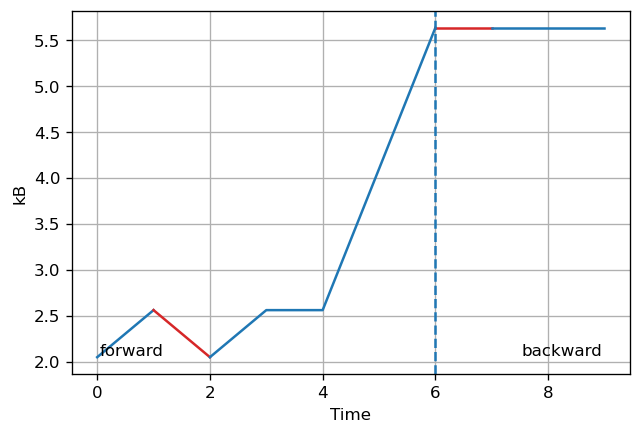

MemoryProfiler (params: 10.0):
    root: Model                 b(4.1 kB)     delta(1.54 kB)    fp(1.02 kB)    f(2.56 kB)   
        lin1: LinBlock          b(5.63 kB)    delta(512.0 bytes) fp(1.54 kB)    f(2.05 kB)   
            lin: Linear         b(5.63 kB)    delta(512.0 bytes) fp(1.54 kB)    f(2.05 kB)       
            relu: ReLU          b(5.63 kB)    delta(512.0 bytes) fp(2.05 kB)    f(2.56 kB)       
        lin2: Linear            b(5.63 kB)    delta(512.0 bytes) fp(2.05 kB)    f(2.56 kB)       

Can...
- mp.css("..."): highlights a particular part of the network
- mp.selector: to get internal k1lib.selector.ModuleSelector object


In [5]:
l = k1lib.Learner.sample()
l.cbs.add(Cbs.Profiler())
l.Profiler.memory.css("#lin1")

In [2]:
!../../../export.py callbacks/profilers/memory

Current dir: /home/kelvin/repos/labs/k1lib, ../../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.8
Uninstalling k1lib-0.8:
  Successfully uninstalled k1lib-0.8
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/fmt.py -> build/lib/k1lib
copying k1lib/selector.py -> build/lib/k1lib
copying k1lib/imports.py -> build/